# TensorFlow Lattice estimators
In this tutorial, we will cover basics of TensorFlow Lattice estimators.

In [18]:
# import libraries
#!pip install tensorflow_lattice
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_lattice as tfl
import tempfile
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from six.moves import urllib

# Synthetic dataset
Here we create a synthetic dataset.

Text(0, 0.5, 'user hapiness')

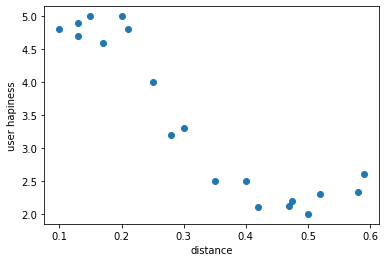

In [5]:
%matplotlib inline

# Training dataset contains one feature, "distance".
train_features = {
    'distance': np.array([1.0, 1.3, 1.5, 2.0, 2.1, 3.0,
                          4.0, 5.0, 1.3, 1.7, 2.5, 2.8,
                          4.7, 4.2, 3.5, 4.75, 5.2,
                          5.8, 5.9]) * 0.1, 
}
train_labels = np.array([4.8, 4.9, 5.0, 5.0,
                         4.8, 3.3, 2.5, 2.0,
                         4.7, 4.6, 4.0, 3.2,
                         2.12, 2.1, 2.5, 2.2,
                         2.3, 2.34, 2.6])
plt.scatter(train_features['distance'], train_labels)
plt.xlabel('distance')
plt.ylabel('user hapiness')

In [6]:
# This function draws two plots.
# Firstly, we draw the scatter plot of `distance` vs. `label`.
# Secondly, we generate predictions from `estimator` distance ranges in
# [xmin, xmax]. 
def Plot(distance, label, estimator, xmin=0.0, xmax=10.0):
    %matplotlib inline
    test_features = {
        'distance': np.linspace(xmin, xmax, num=100)
    }
    # Estimator accepts an input in the form of input_fn (callable).
    # numpy_input_fn creates an input function that generates a dictionary where
    # the key is a feaeture name ('distance'), and the value is a tensor with
    # a shape [batch_size, 1].
    #test_input_fn = tf.estimator.inputs.numpy_input_fn( -> tf version < 2.0
    test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
        x=test_features,
        batch_size=1,
        num_epochs=1,
        shuffle=False)
    # Estimator's prediction is 1d tensor with a shape [batch_size]. Since we
    # set batch_size == 1 in the above, p['predictions'] will contain only one
    # element in each batch, and we fetch this value by p['predictions'][0].
    predictions = [p['predictions'][0]
                   for p in estimator.predict(input_fn=test_input_fn)]
    
    # Plot estimator's response and (distance, label) scatter plot.
    fig, ax = plt.subplots(1, 1)
    ax.plot(test_features['distance'], predictions)
    ax.scatter(distance, label)
    plt.xlabel('distance')
    plt.ylabel('user hapiness')
    plt.legend(['prediction', 'data'])

# DNN Estimator
Now let us define feature columns and use DNN regressor to fit a model.

In [7]:
# Specify feature.
feature_columns = [
    tf.feature_column.numeric_column('distance'),
]
# Define a neural network legressor.
# The first hidden layer contains 30 hidden units, and the second
# hidden layer contains 10 hidden units.
dnn_estimator = tf.estimator.DNNRegressor(
    feature_columns=feature_columns,
    hidden_units=[30, 10],
    activation_fn=tf.nn.relu,
    optimizer=tf.optimizers.SGD(
      learning_rate=0.01,
    ),
)

# Define training input function.
# mini-batch size is 10, and we iterate the dataset over
# 1000 times.
#train_input_fn = tf.estimator.inputs.numpy_input_fn(
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x=train_features,
    y=train_labels,
    batch_size=10,
    num_epochs=1000,
    shuffle=False)

# tf.logging.set_verbosity(tf.logging.ERROR)
# Train this estimator
dnn_estimator.train(input_fn=train_input_fn)

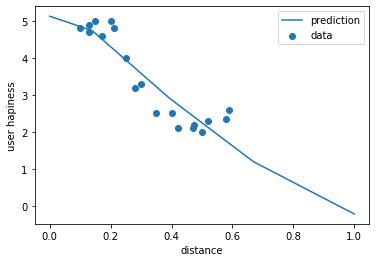

In [8]:
# Response in [0.0, 1.0] range
Plot(train_features['distance'], train_labels, dnn_estimator, 0.0, 1.0)

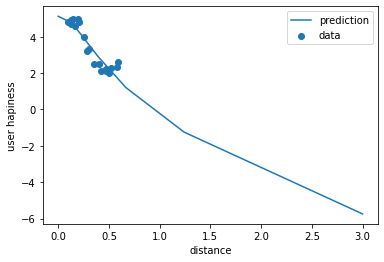

In [9]:
# Now let's increase the prediction range to [0.0, 3.0]
# Note) In most machines, the prediction is going up.
# However, DNN training does not have a unique solution, so it's possible
# not to see this phenomenon.
Plot(train_features['distance'], train_labels, dnn_estimator, 0.0, 3.0)

# TensorFlow Lattice calibrated linear model
Let's use calibrated linear model to fit the data.
Since we only have one example, there's no reason to use a lattice.

In [25]:
# TensorFlow Lattice needs feature names to specify
# per-feature parameters.

pd_train_features = pd.DataFrame(train_features)
pd_train_labels = pd.DataFrame({"labels":train_labels})

feature_names = [fc.name for fc in feature_columns]
num_keypoints = 5

# hparams = tfl.CalibratedLinearHParams(
#     feature_names=feature_names,
#     learning_rate=0.1,
#     num_keypoints=num_keypoints)
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=pd_train_features,
    y=pd_train_labels,
    batch_size=10,
    num_epochs=100,
    shuffle=False)

feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=pd_train_features,
    y=pd_train_labels,
    shuffle=False,
    batch_size=1,
    # Note that we only need one pass over the data.
    num_epochs=1,
    num_threads=1)

feature_configs = [
    tfl.configs.FeatureConfig(
        name='distance',
        monotonicity='decreasing',
        regularizer_configs=[tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),],
    ),
]

# Model config defines the model structure for the estimator.
model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    use_bias=True,
    output_calibration=True,
    regularizer_configs=[
        tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])

# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    config=tf.estimator.RunConfig(tf_random_seed=42))

estimator.train(input_fn=train_input_fn)


# # input keypoint initializers.
# # init_fns are dict of (feature_name, callable initializer).
# keypoints_init_fns = {
#     'distance': lambda: tfl.uniform_keypoints_for_signal(num_keypoints,
#                                                          input_min=0.0,
#                                                          input_max=0.7,
#                                                          output_min=-1.0,
#                                                          output_max=1.0)}

# non_monotnic_estimator = tfl.calibrated_linear_regressor(
#     feature_columns=feature_columns,
#     keypoints_initializers_fn=keypoints_init_fns,
#     hparams=hparams)

# non_monotnic_estimator.train(input_fn=train_input_fn)

AttributeError: 'dict' object has no attribute 'size'

In [0]:
# The prediction goes up!
Plot(train_features['distance'], train_labels, non_monotnic_estimator, 0.0, 1.0)

In [0]:
# Declare distance as a decreasing monotonic input.
hparams.set_feature_param('distance', 'monotonicity', -1)
monotonic_estimator = tfl.calibrated_linear_regressor(
    feature_columns=feature_columns,
    keypoints_initializers_fn=keypoints_init_fns,
    hparams=hparams)

monotonic_estimator.train(input_fn=train_input_fn)

In [0]:
# Now it's decreasing.
Plot(train_features['distance'], train_labels, monotonic_estimator, 0.0, 1.0)

In [0]:
# Even if the output range becomes larger, the prediction never goes up!
Plot(train_features['distance'], train_labels, monotonic_estimator, 0.0, 3.0)